In [ ]:
import pandas as pd

df = pd.read_csv("CCR_final.csv")
df

In [ ]:
import pandas as pd
from darts import TimeSeries

# Assuming 'your_dataset.csv' is a string containing the dataset

# df = pd.read_csv(pd.compat.StringIO('your_dataset.csv'))

# Convert the 'Timestamp' column to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

time_series_list = []
for ccr_id, group in df.groupby('CCR_ID'):
    # Sort the group by 'Timestamp' if not already sorted
    group.sort_values('Timestamp', inplace=True)
    
    # Set the 'Timestamp' column as the index
    group.set_index('Timestamp', inplace=True)
    
    # Exclude the 'CCR_ID' column from numeric conversion and resampling
    # value_cols = ['Elapsed time (minutes)', 'Set B field (T)', 'B field (T)', 'Ramp speed (T/min)', 'Voltage (V)', 'Inner Lower Temperature', 'Outer Lower Temperature', 'Inner Upper Temperature', 'Outer Upper Temperature', '1st Stage Temperature', 'Shield Temperature', '2nd Stage Temperature', ]
    value_cols = ['Elapsed time (minutes)','Setpoint (K)','Sensor A (K)','Sensor B (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)', 'Slope','Intercept','Sensor C (K) or sensor A (sensor unit)','Sensor D (K) or sensor B (sensor unit)']
    
    # Convert the numeric columns to numeric format, handling non-numeric values as NaN
    for col in value_cols:
        group[col] = pd.to_numeric(group[col], errors='coerce')
    
    # Select only numeric columns for resampling
    numeric_cols = group.select_dtypes(include='number').columns
    
    # Resample the numeric columns to a fixed frequency
    group_resampled = group[numeric_cols].resample('30S').mean()  # Adjust '5S' to the desired frequency
    
    # Handle missing values if necessary
    group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropriate method
    
    # Convert the resampled DataFrame to a Darts TimeSeries object
    time_series = TimeSeries.from_dataframe(group_resampled, value_cols=value_cols)
    
    time_series_list.append(time_series)


In [ ]:
print(time_series_list[0])

In [ ]:
print(len(time_series_list))

In [ ]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (time_series_list[1]).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# fix python path if working locally
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
len(time_series_list[0])

2430

In [ ]:
time_series_list_scaled = []

for time_series in time_series_list:
    scaler = Scaler()
    time_series_list_scaled.append(scaler.fit_transform(time_series))

In [16]:
# print(time_series_list_scaled[0].columns)
from darts import TimeSeries
temp = []
# Assuming you have a Darts TimeSeries object named 'ts'

# Convert the TimeSeries to a pandas DataFrame
for ts in time_series_list_scaled:
    df = ts.pd_dataframe()

    # Rename the columns in the pandas DataFrame
    new_column_names = ['Normalized Elapsed time (minutes)','Normalized Setpoint (K)','Normalized Sensor A (K)','Normalized Sensor B (K)', 'Normalized Heater Output % (0-100)', 'Normalized Heater Range (integer 0-5)', 'Normalized Slope','Normalized Intercept','Normalized Sensor C (K) or sensor A (sensor unit)','Normalized Sensor D (K) or sensor B (sensor unit)']

    
#     new_column_names = ['Normalized Elapsed time (minutes)', 'Normalized Set B field (T)', 'Normalized B field (T)',
#        'Normalized Ramp speed (T/min)', 'Normalized Voltage (V)', 'Normalized Inner Lower Temperature',
#        'Normalized Outer Lower Temperature', 'Normalized Inner Upper Temperature',
#        'Normalized Outer Upper Temperature', 'Normalized 1st Stage Temperature',
#        'Normalized Shield Temperature', 'Normalized 2nd Stage Temperature']  # Replace with the new column names you want
    df.columns = new_column_names

    # Convert the modified pandas DataFrame back to a Darts TimeSeries
    df = df.drop(['Normalized Elapsed time (minutes)','Normalized Sensor A (K)','Normalized Sensor B (K)','Normalized Heater Range (integer 0-5)','Normalized Sensor C (K) or sensor A (sensor unit)','Normalized Sensor D (K) or sensor B (sensor unit)'], axis=1)
    temp.append(TimeSeries.from_dataframe(df))
time_series_list_scaled = temp
print(time_series_list_scaled[0].columns)

Index(['Normalized Setpoint (K)', 'Normalized Heater Output % (0-100)',
       'Normalized Slope', 'Normalized Intercept'],
      dtype='object', name='component')


In [17]:
print((time_series_list[0]).columns)

Index(['Elapsed time (minutes)', 'Setpoint (K)', 'Sensor A (K)',
       'Sensor B (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)',
       'Slope', 'Intercept', 'Sensor C (K) or sensor A (sensor unit)',
       'Sensor D (K) or sensor B (sensor unit)'],
      dtype='object', name='component')


In [18]:
from darts import TimeSeries

covariates = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['Setpoint (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)', 'Slope','Intercept',]
    # columns_to_keep = ['Elapsed time (minutes)', 'Ramp speed (T/min)', 'Inner Lower Temperature', 
    #                    'Outer Lower Temperature', 'Inner Upper Temperature',
    #                    'Outer Upper Temperature', '1st Stage Temperature',
    #                    'Shield Temperature', '2nd Stage Temperature']
    covariate_ts_df = ts_df[columns_to_keep]
    covariates.append(TimeSeries.from_dataframe(covariate_ts_df))


In [19]:
updated_covariates = []
for i in range(len(covariates)):
    df = covariates[i].pd_dataframe()
    # for time_series in time_series_list_scaled:
    temp = time_series_list_scaled[i].pd_dataframe()
    for col in temp.columns:
        df[col] = temp[col]
    updated_covariates.append(TimeSeries.from_dataframe(df))
    
print(updated_covariates[0].columns)
covariates = updated_covariates

Index(['Setpoint (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)',
       'Slope', 'Intercept', 'Normalized Setpoint (K)',
       'Normalized Heater Output % (0-100)', 'Normalized Slope',
       'Normalized Intercept'],
      dtype='object', name='component')


In [21]:
from darts import TimeSeries

# ts_df = ts.pd_dataframe()
time_final = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['Sensor A (K)','Sensor B (K)', 'Sensor C (K) or sensor A (sensor unit)','Sensor D (K) or sensor B (sensor unit)']
    covariate_ts_df = ts_df[columns_to_keep]
    time_final.append(TimeSeries.from_dataframe(covariate_ts_df))
    
print(len(time_final[0].columns))

4


In [25]:
model = TransformerModel(
    input_chunk_length=50,
    output_chunk_length=10,
    model_name="model_test",
    activation="relu",
    # random_state=42,
    save_checkpoints=True,
    # force_reset=True,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]}
)

train, test = [], []

for time_series in time_final:
    train_length = int(len(time_series) * 0.8)
    train.append(time_series[:train_length])
    test.append(time_series[train_length:])

# forecast = model.predict(len(val_series))

In [ ]:
model.fit(
    series=train,
    past_covariates=covariates,
);

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
model.save('model_test.pth')

In [ ]:
# fix python path if working locally
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

loaded_model = TCNModel.load('base.pth')

In [ ]:
len(test[1])

In [ ]:
num = 3

In [ ]:
n_forecast = len(test[num])  # Replace `test` with your test set
pred_series = loaded_model.predict(n=n_forecast, series=train[num], past_covariates = covariates[num])  # Adjust the `n` parameter as needed

In [ ]:
from darts.metrics import mape, rmse

mape_score = mape(pred_series, test[num])  # Replace `test` with your true future values
rmse_score = rmse(pred_series, test[num])  # Replace `test` with your true future values

print(f"MAPE: {mape_score:.2f}%")
print(f"RMSE: {rmse_score:.2f}")

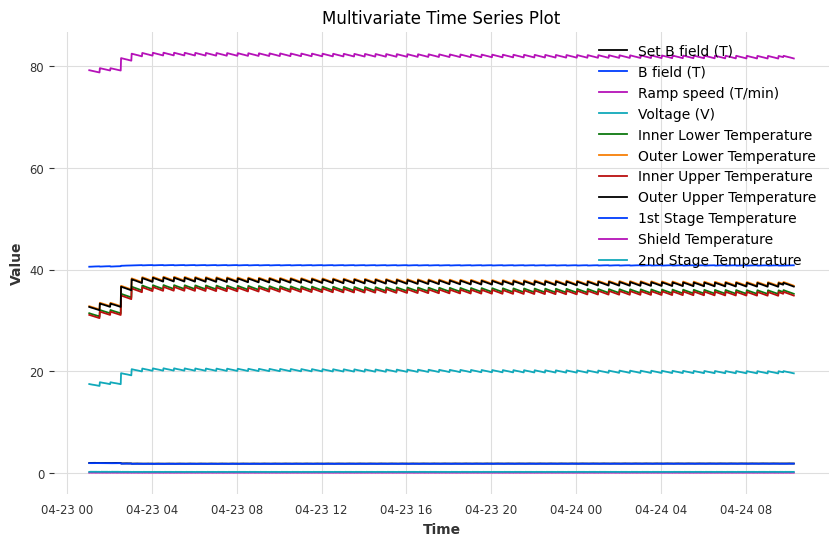

In [50]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (pred_series).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()


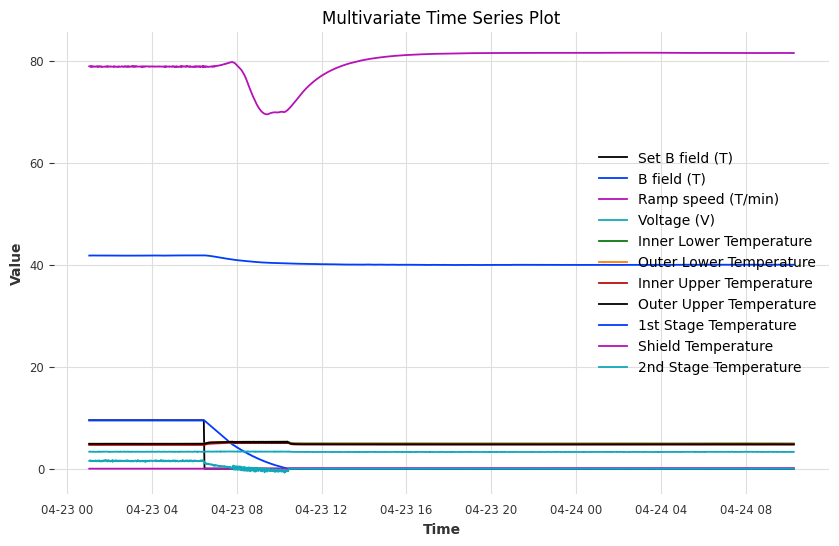

In [51]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (test[num]).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Assuming you have already trained your model and have a Darts TimeSeriesModel named 'model'
training_loss_history = loaded_model.history['train_loss']
training_accuracy_history = loaded_model.history['train_accuracy']

AttributeError: 'TransformerModel' object has no attribute 'history'